In [1]:
from project_lib import *

In [2]:
df = pd.read_csv('dataset_tmc.csv', parse_dates = ['Dates'], date_format = '%d/%m/%y')
df.columns = [i.lower() for i in df.columns]
df.columns = [i.replace(' ','_') for i in df.columns]
df = df.set_index('dates')

# Check NaNs
if df.isna().sum().sum() != 0:
    print('check NaNs in data')

# Drop Sat&Sun if any
df = df[df.index.dayofweek<5]

# as convention 2 weeks is 10 trading days, 1 month is 21 trading days so that each year has 252 trading days


In [24]:
# STRATEGY PARAMETERS
TRADED_SECURITIES = [
            'us_staples',
            # 'eu_healthcare', 'japan', 'brazil', 'nasdaq', 'us_2y',
            # 'us_15y', 'germany_10y', 'uk_15y', 'us_hy', 'oil', 'ind_metals', 'agri',
            # 'gold', 'silver', 'eurusd', 'usdjpy', 'chfjpy', 'eurbrl', 'gbpmxn'
    ]
LONG_PARAMS = {10:0.05, 21:0.15, 63:0.25} # dict with lenght of window as key and percentile for longs as values
SHORT_PARAMS = {10:0.95, 21:0.85, 63:0.75} # dict with lenght of window as key and percentile for shorts as values
MA_FAST_WDW = 20
MA_SLOW_WDW = 60

In [25]:
for security_id in TRADED_SECURITIES:
    signal = meanrev_signal(
                df[security_id],
                long_params = LONG_PARAMS,
                short_params = SHORT_PARAMS,
                ma_fast_wdw = MA_FAST_WDW,
                ma_slow_wdw = MA_SLOW_WDW
                )

<Axes: xlabel='dates'>

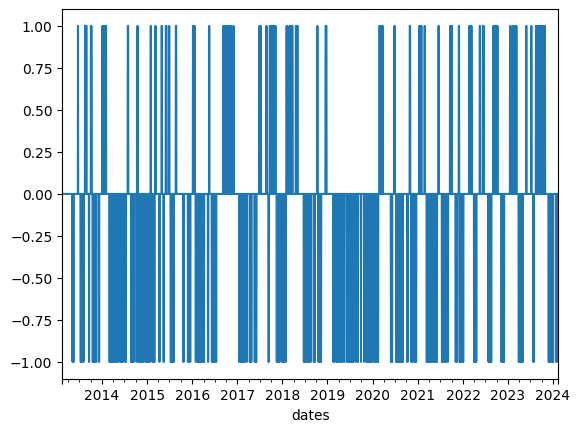

In [26]:
signal.plot()

In [28]:
security_id

'us_staples'